<a href="https://colab.research.google.com/github/ali-kmirzaei/NN-and-DL/blob/main/TransferLearningTut.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libs and Drive

In [1]:
import numpy as np
import time
import PIL.Image as Image
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import datetime
import glob
import os
import tensorflow_datasets as tfds

%load_ext tensorboard

In [3]:
# import dataset from google drive
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

Mounted at /content/gdrive
 4001419029.zip  'Colab Notebooks'   last.pt
 augDataset.zip   datasets.zip	     mainDataset.zip


In [ ]:
!unzip /mydrive/datasets -d datasets

In [20]:
!mv datasets/datasets/augDataset/ datasets/augDataset/
!mv datasets/datasets/mainDataset/ datasets/mainDataset/

In [21]:
!rm -rf datasets/datasets

# Create Dataset

In [36]:
SIZE = 224
BATCH_SIZE = 64
VALIDATION_SPLIT = 0.3
# DATA_DIR = 'datasets/mainDataset/'
DATA_DIR = 'datasets/augDataset/'

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  DATA_DIR,
  labels = 'inferred',
  class_names = ['Books', 'Pens'],
  shuffle = True,
  validation_split = VALIDATION_SPLIT,
  seed = 123,
  image_size = (SIZE, SIZE),
  subset = 'training',
  batch_size = BATCH_SIZE
  )

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  DATA_DIR,
  labels = 'inferred',
  class_names = ['Books', 'Pens'],
  shuffle = True,
  validation_split = VALIDATION_SPLIT,
  seed = 123,
  image_size = (SIZE, SIZE),
  subset = 'validation',
  batch_size = BATCH_SIZE
  )


Found 500 files belonging to 2 classes.
Using 350 files for training.
Found 500 files belonging to 2 classes.
Using 150 files for validation.


In [37]:
class_names = np.array(train_dataset.class_names)
print(class_names)

['Books' 'Pens']


In [38]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [39]:
for image_batch, labels_batch in val_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)

(64, 224, 224, 3)
(64,)
(64, 224, 224, 3)
(64,)
(22, 224, 224, 3)
(22,)


# MODEL

In [40]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor_model = mobilenet_v2
feature_extractor_layer = hub.KerasLayer(feature_extractor_model, input_shape=(SIZE, SIZE, 3), trainable=False)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(2 , activation='softmax')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_1 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
NUM_EPOCHS = 5
LEARNING_RATE = 0.001
# LOSS = 'categorical_crossentropy'
LOSS = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
METRICS = ['accuracy']
OPT = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-07, amsgrad = False)


log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1) # Enable histogram computation for every epoch.
print(log_dir)


model.compile(optimizer=OPT, loss=LOSS, metrics=METRICS)
history = model.fit(train_dataset, validation_data=val_dataset, epochs=NUM_EPOCHS, callbacks=tensorboard_callback)

In [ ]:
%tensorboard --logdir logs/fit

# Prediction Test

In [42]:
predicted_batch = model.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = list()
for pid in predicted_id:
  predicted_label_batch.append(class_names[pid])
predicted_label_batch

['Pens',
 'Pens',
 'Books',
 'Pens',
 'Pens',
 'Pens',
 'Pens',
 'Books',
 'Pens',
 'Books',
 'Pens',
 'Books',
 'Pens',
 'Pens',
 'Pens',
 'Books',
 'Books',
 'Pens',
 'Books',
 'Pens',
 'Pens',
 'Pens']

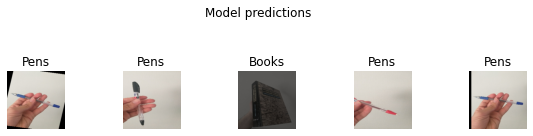

In [43]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(5):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")